In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

In [2]:
# config = '24I/ml_0p01'
# config = '24I/ml_0p005'
# config = '32I/ml0p008'
# config = '32I/ml0p006'
config = '32I/ml0p004'
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/3pt_output.h5'
n_ops = 5

In [3]:
f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
C2pt_tavg = f['C2pt'][()]
C3pt_tavg = f['C3pt'][()]
Cnpt = f['Cnpt'][()]
R = f['R'][()]
f.close()

In [4]:
R_boot = bootstrap(R)
print(R_boot.shape)
R_μ = np.mean(R_boot, axis = 0)
R_σ = np.std(R_boot, axis = 0)

(50, 5, 64, 64)


In [5]:
# TODO figure out the region that David plotted-- might be in fits/xml/O1.xml

It looks like David may have found a few regions to fit at each sep: in ml0p004/fits/xml/O1.xml, he is specifying the following regions: 

sep | (tmin, tmax)

15  | (7, 8)

16  | (7, 9)

17  | (7, 10)

18  | (7, 11)

19  | (7, 12)

20  | (7, 13)

...

25  | (7, 18)

So as sep moves up, he increases the maximum fitting range for the data at sep by 1.

TRY TO REPLICATE SOME OF THE PLOTS IN 24I/ml_0p01/fits/results/plots-- see if I can get O1.19 to look the same, and O2.21

Note that I believe these are already jackknifed, i.e. the data in pion_0vbb_4quark_2p.3.1540 for example has already been resampled. This means I shouldn't expect them to match completely, but rather I should expect them to be within statistical error. The second (weight) column also matches up with the resampled uncertainty, as if you evaluate $R_\sigma$ for the corresponding time slice, it compares well to the data in the uncertainty column.

O1.19 matches if I divide my output by 4?
At SEP = 21 (in the filename), so far I've checked that O2, O3, O1p, and O2p match one another. 

TODO why doesn't O1 match up? My O1 that I've saved has to be divided by 4 to match David's graph, although each other operator is fine.

In [6]:
# # Plot C3(t, 2t) / C2(2t)
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, 2 * t]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, 2 * t]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [7]:
# # Plot C3(t, sep) / C2(sep)
# sep = 21
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, sep]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, sep]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [8]:
# Try to replicate the plots in 24I/ml_0p01/plots, this is what is generated by plot_pion_0vbb_4quark_ratios.py
# data_plot, σ_plot = np.zeros((n_ops, T), dtype = np.float64), np.zeros((n_ops, T), dtype = np.float64)
# plot_domain = range(T)
# for i in range(n_ops):
#     for sep in range(T):
#         if sep % 2 == 0:
#             data_plot[i, sep] = np.real(R_μ[i, sep // 2, sep])
#             σ_plot[i, sep] = np.real(R_σ[i, sep // 2, sep])
#         else:
#             data_plot[i, sep] = np.real((R_μ[i, sep // 2, sep] + R_μ[i, sep // 2 + 1, sep]) / 2)
#             σ_plot[i, sep] = np.real((R_σ[i, sep // 2, sep] + R_σ[i, sep // 2 + 1, sep]) / 2)

data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_μ = np.mean(data_slice, axis = 0)
data_plot_σ = np.std(data_slice, axis = 0)

<IPython.core.display.Javascript object>


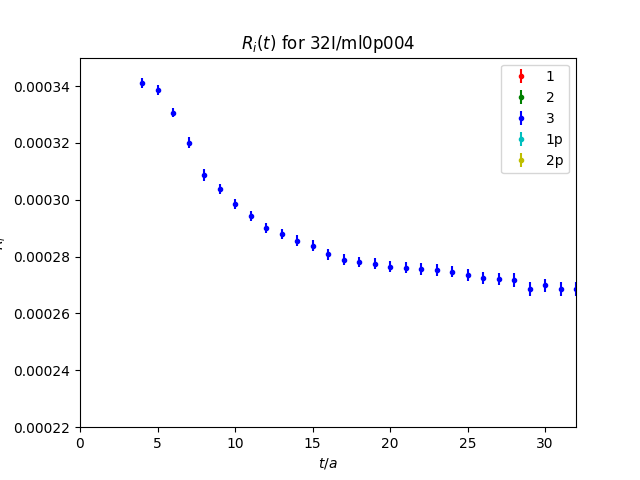

In [9]:
plt.figure()
colors = ['r', 'g', 'b', 'c', 'y']
op_label = ['1', '2', '3', '1p', '2p']
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = op_label[i])
plt.title('$R_i(t)$ for ' + config)
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
# plt.xlim((0, 21.5))
plt.xlim((0, T // 2))
plt.ylim((0.00022, 0.00035))
plt.legend()
plt.show()

In [10]:
# plt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/' + config + '/O3_t_2t.pdf'
# plt.savefig(plt_path)

In [11]:
# fit each linear region to a constant
# fit_regions = [
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26)
# ]
fit_regions = [
    range(15, 26),
    range(15, 26),
    range(18, 26),
    range(15, 26),
    range(15, 26)
]
c, σc = [], []
for i in range(n_ops):
    ci, σci = fit_constant(fit_regions[i], data_slice[:, i])
    c.append(ci)
    σc.append(σci)

In [12]:
# order 1, 2, 3, 1p, 2p
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
for i in range(n_ops):
    print(labels[i] + ': ' + str(c[i]) + ' \pm ' + str(σc[i]))

O1: -0.011742648539891527 \pm 7.88810703766851e-05
O2: -0.018398946172002568 \pm 0.0002027935879805359
O3: 0.0002760482625688332 \pm 1.854663291094517e-06
O1p: -0.037019804958845215 \pm 0.00025305591553743706
O2p: 0.004592147051289714 \pm 5.045782516441156e-05


<IPython.core.display.Javascript object>


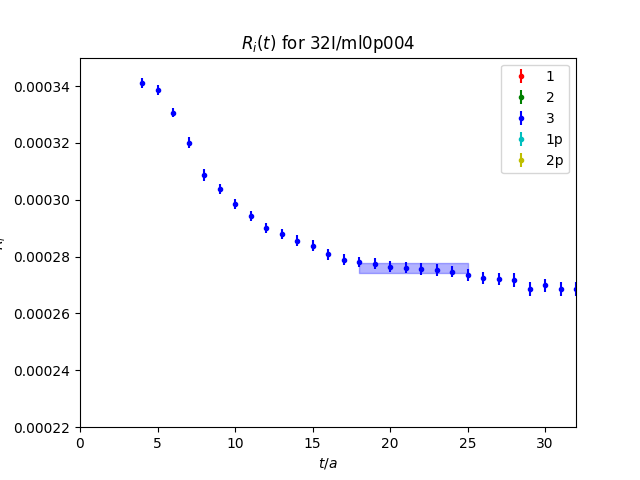

In [13]:
plt.figure()
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = op_label[i])
    plt.fill_between(fit_regions[i], c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
plt.title('$R_i(t)$ for ' + config)
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
plt.xlim((0, T // 2))
plt.ylim((0.00022, 0.00035))
plt.legend()
plt.show()

In [14]:
# fit_plt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/O3_t_2t.pdf'
# plt.savefig(fit_plt_path)

In [15]:
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
# fout = h5py.File(out_file, 'w')
# for i in range(n_ops):
#     fout[labels[i] + 'fitrange'] = fit_regions[i]
#     fout[labels[i] + '/mean'] = c[i]
#     fout[labels[i] + '/std'] = σc[i]
# fout.close()

In [16]:
# MAKE SURE AFTER EDITING THINGS WE GET THE SAME RESULTS AS THIS
# O1: -0.011742648539891527 \pm 7.88810703766851e-05
# O2: -0.018398946172002568 \pm 0.0002027935879805359
# O3: 0.0002760482625688332 \pm 1.854663291094517e-06
# O1p: -0.037019804958845215 \pm 0.00025305591553743706
# O2p: 0.004592147051289714 \pm 5.045782516441156e-05